# Verification of the Tikhonov and Total Variation regularization implementation (2D)

This notebook is dedicated to check the implementation and the correctness of the first derivative of two classic regularization operators: Tikhonov and Total Variations. The numerical check is performed by a finite difference approximation of the first derivative.

- Import the required modules

In [1]:
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
from pyrtid.forward.models import Geometry
from pyrtid.inverse.regularization import (
    TikhonovRegularizator,
    TikhonovMatRegularizator,
    TVRegularizator,
    TVMatRegularizator,
)
from pyrtid.utils import NDArrayFloat

In [2]:
pyrtid.utils.show_versions()

- Some configurations for the plots

In [3]:
pyrtid.plot.apply_default_rc_params()

## Case study

Let's start by defining a 2D grid with some interfaces.

In [4]:
nx: int = 15
ny: int = 26
dx: float = 7.5
dy: float = 2.6
param: NDArrayFloat = np.ones((nx, ny), dtype=np.float64)
param[0:10, 5:15] = 5.0
param[6:14, 7:14] = 10.0
param[8:9, 2:25] = 20.0
extent = (0, nx * dx, 0, ny * dy)

- Plot the parameter structure

Text(0, 0.5, 'Y [m]')

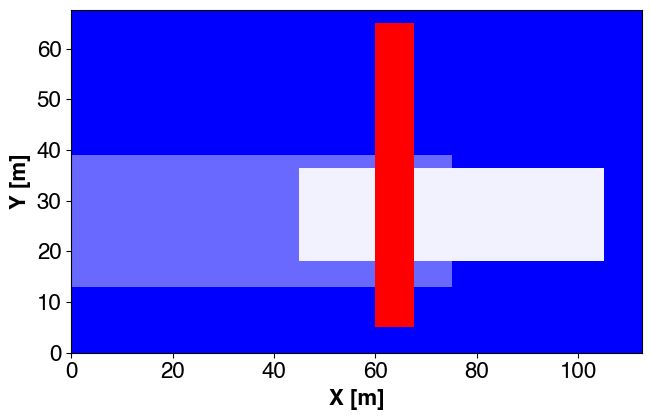

In [5]:
plt.imshow(param.T, cmap="bwr", extent=extent, origin="lower")
plt.xlabel("X [m]", fontweight="bold")
plt.ylabel("Y [m]", fontweight="bold")

- Add some noise to check all borders

In [6]:
# Add some noise with a seed
rng = np.random.default_rng(26659)
param += rng.random((nx, ny)) * 5.0

Text(0, 0.5, 'Y [m]')

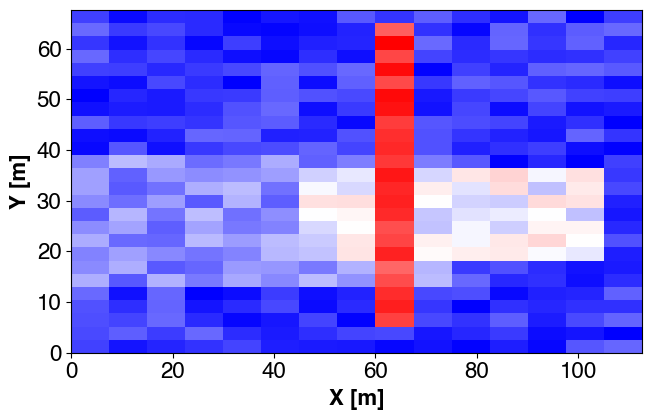

In [7]:
plt.imshow(param.T, cmap="bwr", extent=extent, origin="lower")
plt.xlabel("X [m]", fontweight="bold")
plt.ylabel("Y [m]", fontweight="bold")

## Tickonov regularisation

### Forward Difference Approximations


- Loss function computation

In [8]:
regularizator_tk = TikhonovRegularizator(dx, dy)
print(f"loss_reg_tk = {regularizator_tk.eval_loss(param)}")

regularizator_tk_mat = TikhonovMatRegularizator(geometry=Geometry(nx, ny, dx, dy))
print(f"loss_reg_tk = {regularizator_tk_mat.eval_loss(param)}")

regularizator_tv = TVRegularizator(dx, dy, eps=1e-20)
print(f"loss_reg_tv = {regularizator_tv.eval_loss(param)}")

regularizator_tv_mat = TVMatRegularizator(geometry=Geometry(nx, ny, dx, dy), eps=1e-20)
print(f"loss_reg_tv = {regularizator_tv_mat.eval_loss(param)}")

loss_reg_tk = 374.13952602512234
loss_reg_tk = 374.13952602512245
loss_reg_tv = 397.42747105634584
loss_reg_tv = 397.42747105634584


- Gradient computation and verification

In [9]:
# We check the formulation by finite differences for the three cases
for regularizator in [regularizator_tk, regularizator_tk_mat, regularizator_tv]:
    grad_reg_fd = regularizator.eval_loss_gradient(param, is_finite_differences=True)
    grad_reg_analytic = regularizator.eval_loss_gradient(param)
    np.testing.assert_allclose(grad_reg_fd, grad_reg_analytic, atol=1e-5)

In [10]:
grad_tk_fd = regularizator_tk.eval_loss_gradient(param, True)
grad_tk_an = regularizator_tk.eval_loss_gradient(param, False)
grad_tk_mat_fd = regularizator_tk_mat.eval_loss_gradient(param, True)
grad_tk_mat_an = regularizator_tk_mat.eval_loss_gradient(param, False)
grad_tv_fd = regularizator_tv.eval_loss_gradient(param, True)
grad_tv_an = regularizator_tv.eval_loss_gradient(param, False)
grad_tv_mat_fd = regularizator_tv_mat.eval_loss_gradient(param, True)
grad_tv_mat_an = regularizator_tv_mat.eval_loss_gradient(param, False)

- Gradient plot (isotropic vs. anisotropic / finite difference vs. analytical)

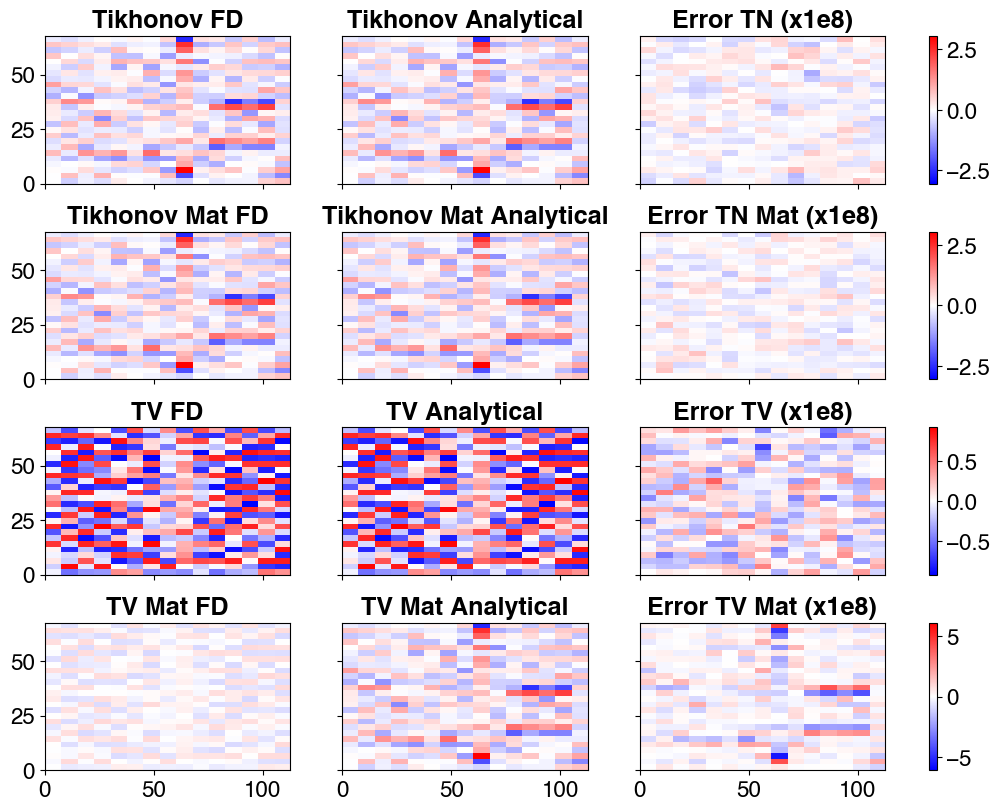

In [11]:
plotter = ngp.NestedGridPlotter(
    plt.figure(constrained_layout=True, figsize=(10, 8)),
    builder=ngp.SubplotsMosaicBuilder(
        mosaic=[
            ["ax1-1", "ax1-2", "ax1-3"],
            ["ax2-1", "ax2-2", "ax2-3"],
            ["ax3-1", "ax3-2", "ax3-3"],
            ["ax4-1", "ax4-2", "ax4-3"],
        ],
        sharey=True,
        sharex=True,
    ),
)

ngp.multi_imshow(
    plotter.axes[:3],
    plotter.fig,
    data={
        "Tikhonov FD": grad_tk_fd,
        "Tikhonov Analytical": grad_tk_an,
        "Error TN (x1e8)": (grad_tk_fd - grad_tk_an) * 1e8,
    },
    is_symmetric_cbar=True,
    imshow_kwargs={"extent": extent, "aspect": "equal"},
)

ngp.multi_imshow(
    plotter.axes[3:6],
    plotter.fig,
    data={
        "Tikhonov Mat FD": grad_tk_mat_fd,
        "Tikhonov Mat Analytical": grad_tk_mat_an,
        "Error TN Mat (x1e8)": (grad_tk_mat_fd - grad_tk_mat_an) * 1e8,
    },
    is_symmetric_cbar=True,
    imshow_kwargs={"extent": extent, "aspect": "equal"},
)

ngp.multi_imshow(
    plotter.axes[6:9],
    plotter.fig,
    data={
        "TV FD": grad_tv_fd,
        "TV Analytical": grad_tv_an,
        "Error TV (x1e8)": (grad_tv_fd - grad_tv_an) * 1e8,
    },
    is_symmetric_cbar=True,
    imshow_kwargs={"extent": extent, "aspect": "equal"},
)

ngp.multi_imshow(
    plotter.axes[9:],
    plotter.fig,
    data={
        "TV Mat FD": grad_tv_mat_fd,
        "TV Mat Analytical": grad_tv_mat_an,
        "Error TV Mat (x1e8)": (grad_tv_mat_fd - grad_tv_mat_an) * 1,
    },
    is_symmetric_cbar=True,
    imshow_kwargs={"extent": extent, "aspect": "equal"},
)